In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from heapq import heappush, heappop
from itertools import permutations

class VoxelPathfinder:
    def __init__(self, grid_size=10, square_start=0, square_size=10, hole_position=(1, 2), hole_size=2):
        
        self.grid_size = grid_size
        self.square_start = square_start
        self.square_size = square_size
        self.hole_position = hole_position
        self.hole_size = hole_size
        self.voxel_grid = self.generate_voxel_with_obstacle()
    
    def generate_voxel_with_obstacle(self):
        # Initialize the voxel grid with zeros (empty space)
        voxel_grid = np.zeros((self.grid_size, self.grid_size, self.grid_size), dtype=bool)

        # Create a wider square in the middle of the grid
        voxel_grid[self.square_start:self.square_start + self.square_size, :, self.grid_size // 2] = True

        # Define the hole's coordinates
        hole_start_x, hole_start_y = self.hole_position
        hole_end_x = hole_start_x + self.hole_size
        hole_end_y = hole_start_y + self.hole_size

        # Create a hole in the square
        voxel_grid[hole_start_x:hole_end_x, hole_start_y:hole_end_y, self.grid_size // 2] = False

        return voxel_grid
    
    def plot_voxel_grid(self, points=None, path=None):
        # Plotting
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Visualize the voxels
        ax.voxels(self.voxel_grid, edgecolor='k')

        # Setting the labels
        ax.set_xlabel('X axis')
        ax.set_ylabel('Y axis')
        ax.set_zlabel('Z axis')

        # plot point A and B as scatters
        if points is not None:
            for point in points:
                ax.scatter(point[0], point[1], point[2], color='r', s=100)

        if path is not None:
            # plot the path
            ax.plot(path[:,0], path[:,1], path[:,2], color='r', linewidth=2)
    
    def path_length(self, path):
        # Calculate the length of a path
        length = 0
        for i in range(1, len(path)):
            # Calculate the Euclidean distance between consecutive points in the path
            length += np.sqrt(sum((np.array(path[i]) - np.array(path[i-1])) ** 2))
        return length
    
    def heuristic(self, a, b):
        # Calculate the Euclidean distance (heuristic) between two points
        return np.sqrt(sum((np.array(a) - np.array(b)) ** 2))
    
    def astar(self, start, goal):
        neighbors = [(0, 1, 0), (0, -1, 0), (1, 0, 0), (-1, 0, 0), (0, 0, 1), (0, 0, -1)]
        close_set = set()  # Set to store explored nodes
        came_from = {}     # Dictionary to store the path for each node
        gscore = {start: 0}  # Dictionary to store the cost to reach each node from the start
        fscore = {start: self.heuristic(start, goal)}  # Dictionary to store the total estimated cost for each node
        oheap = []  # Priority queue to store nodes to be explored
        heappush(oheap, (fscore[start], start))  # Add the start node to the priority queue

        while oheap:
            current = heappop(oheap)[1]  # Get the node with the lowest estimated cost from the priority queue
            if current == goal:
                # Reconstruct the path from the goal node to the start node
                data = []
                while current in came_from:
                    data.append(current)
                    current = came_from[current]
                return data

            close_set.add(current)  # Mark the current node as explored
            for i, j, k in neighbors:
                neighbor = current[0] + i, current[1] + j, current[2] + k  # Calculate the coordinates of the neighbor node

                # Calculate the tentative cost to reach the neighbor node from the current node
                tentative_g_score = gscore[current] + self.heuristic(current, neighbor)

                if 0 <= neighbor[0] < self.voxel_grid.shape[0] and 0 <= neighbor[1] < self.voxel_grid.shape[1] and 0 <= neighbor[2] < self.voxel_grid.shape[2]:
                    if self.voxel_grid[neighbor[0]][neighbor[1]][neighbor[2]]:
                        continue
                else:
                    continue

                if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                    continue

                if  tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in oheap]:
                    came_from[neighbor] = current
                    gscore[neighbor] = tentative_g_score
                    fscore[neighbor] = tentative_g_score + self.heuristic(neighbor, goal)
                    heappush(oheap, (fscore[neighbor], neighbor))

        return False

    def shortest_path(self, points, sequence=False):
        if sequence:
            return self.connect_points_in_order(points)
        else:
            return self.shortest_path_all_points(points)

    def connect_points_in_order(self, points):
        total_path = []
        for i in range(len(points) - 1):
            path = self.astar(points[i], points[i+1])
            if path:
                total_path.extend(path)
            else:
                return None  # If no path exists for any segment
        return total_path

    def shortest_path_all_points(self, points):
        shortest_path = None
        min_length = float('inf')

        for perm in permutations(points):
            current_path = self.connect_points_in_order(perm)
            if current_path:
                current_length = self.path_length(current_path)
                if current_length < min_length:
                    min_length = current_length
                    shortest_path = current_path

        return shortest_path

17.0


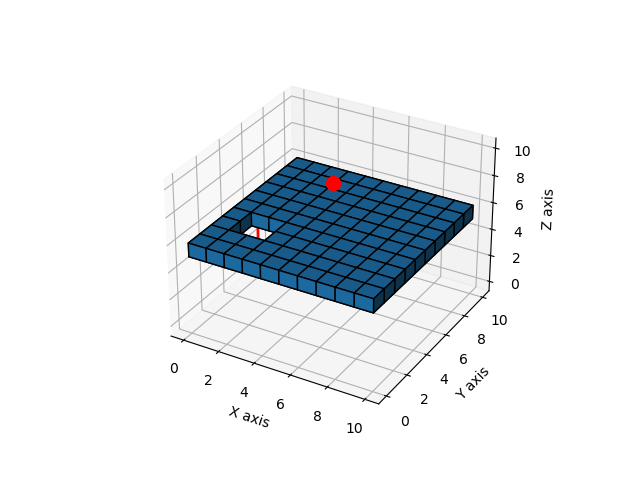

In [19]:
# Create an instance of VoxelPathfinder
pathfinder = VoxelPathfinder()

# Starting points 
point_A = (5,5,1)
point_B = (5,5,9)

path = pathfinder.shortest_path(points=[point_A, point_B])
length = pathfinder.path_length(path)
print(length)
# Show plot
pathfinder.plot_voxel_grid(points=[point_A, point_B], path=np.array(path))

23.0


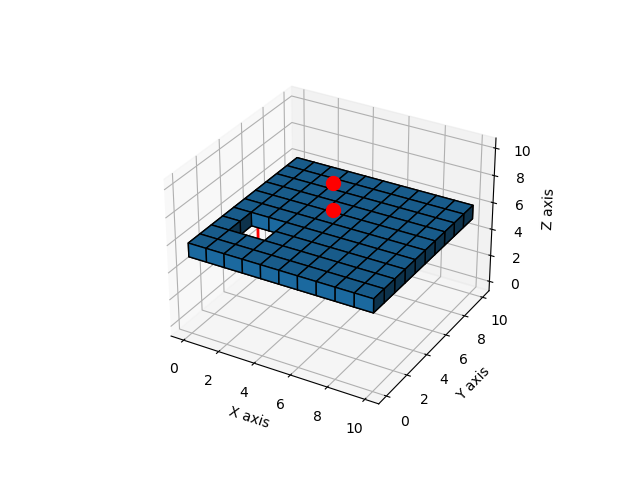

In [25]:
# Create an instance of VoxelPathfinder
pathfinder = VoxelPathfinder()

# Starting points 
point_A = (5,5,1)
point_B = (5,5,9)
point_C = (5,5,7)

path = pathfinder.shortest_path(points=[point_A, point_B,point_C],sequence=True)
length = pathfinder.path_length(path)
print(length)
# Show plot
pathfinder.plot_voxel_grid(points=[point_A, point_B,point_C], path=np.array(path))

In [13]:
import unittest

class TestVoxelPathfinder(unittest.TestCase):

    def test_voxel_grid_generation(self):
        pathfinder = VoxelPathfinder(grid_size=10, square_start=2, square_size=5, hole_position=(3, 4), hole_size=2)
        self.assertFalse(pathfinder.voxel_grid[3][4][5])  # Checking if the hole exists
        self.assertTrue(pathfinder.voxel_grid[2][3][5])   # Checking if the square exists

    def test_astar_path_finding(self):
        pathfinder = VoxelPathfinder()
        path = pathfinder.astar((5, 5, 1), (5, 5, 9))
        self.assertIsNotNone(path)  # Path should exist

        no_path = pathfinder.astar((0, 0, 0), (10, 10, 10))
        self.assertFalse(no_path)  # Path should not exist

    def test_path_length_calculation(self):
        pathfinder = VoxelPathfinder()
        path = [(0, 0, 0), (1, 1, 1), (2, 2, 2)]
        expected_length = 2 * np.sqrt(3)  # Length of 2 diagonal steps
        self.assertAlmostEqual(pathfinder.path_length(path), expected_length)

    def test_heuristic_function(self):
        pathfinder = VoxelPathfinder()
        distance = pathfinder.heuristic((0, 0, 0), (3, 4, 0))
        expected_distance = 5  # 3-4-5 triangle
        self.assertEqual(distance, expected_distance)

    def test_obstacle_navigation(self):
        pathfinder = VoxelPathfinder(hole_position=(5, 5), hole_size=1)
        path = pathfinder.astar((5, 4, 5), (5, 6, 5))
        self.assertIsNotNone(path)  # Path should exist and navigate around the hole

    def test_boundary_conditions(self):
        pathfinder = VoxelPathfinder(grid_size=10)
        outside_path = pathfinder.astar((0, 0, 0), (10, 10, 10))
        self.assertFalse(outside_path)  # Path should not exist as goal is outside grid

if __name__ == '__main__':
    unittest.main()



usage: ipykernel_launcher.py [-h] [-v] [-q] [--locals] [-f] [-c] [-b]
                             [-k TESTNAMEPATTERNS]
                             [tests ...]
ipykernel_launcher.py: error: argument -f/--failfast: ignored explicit argument '/Users/thor/Library/Jupyter/runtime/kernel-v2-407476QJQ8FXThNCn.json'


AttributeError: 'tuple' object has no attribute 'tb_frame'